### Model Building, Scoring and Evaluation using XGBoost

In [29]:
# Import Libraries
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T

from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.metrics import *

import json
import pandas as pd
import seaborn as sns

In [30]:
# Create Snowpark Session
with open('creds.json') as f:
    connection_parameters = json.load(f)

session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "CC_DB"."PUBLIC"
Current Warehouse: "CC_WH"


### Model Building

In [3]:
train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

In [ ]:
# Fitting a XGBoost model using snowpark-ml
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

In [9]:
# Initialize the XGBClassifier
xgbm = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    seed=42,
    input_cols=feature_cols,  # List of feature column names
    label_cols=target_col ,  # The target column name
)

# Fit the model
xgbm.fit(train_sdf)

Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.
The version of package 'xgboost' in the local environment is 2.1.4, which does not fit the criteria for the requirement 'xgboost==2.1.1'. Your UDF might not work when the package version is different between the server and your local environment.
/Users/navisha/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and ser

In [14]:
xgbm_local = xgbm.to_xgboost()
xgbm_local

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: >

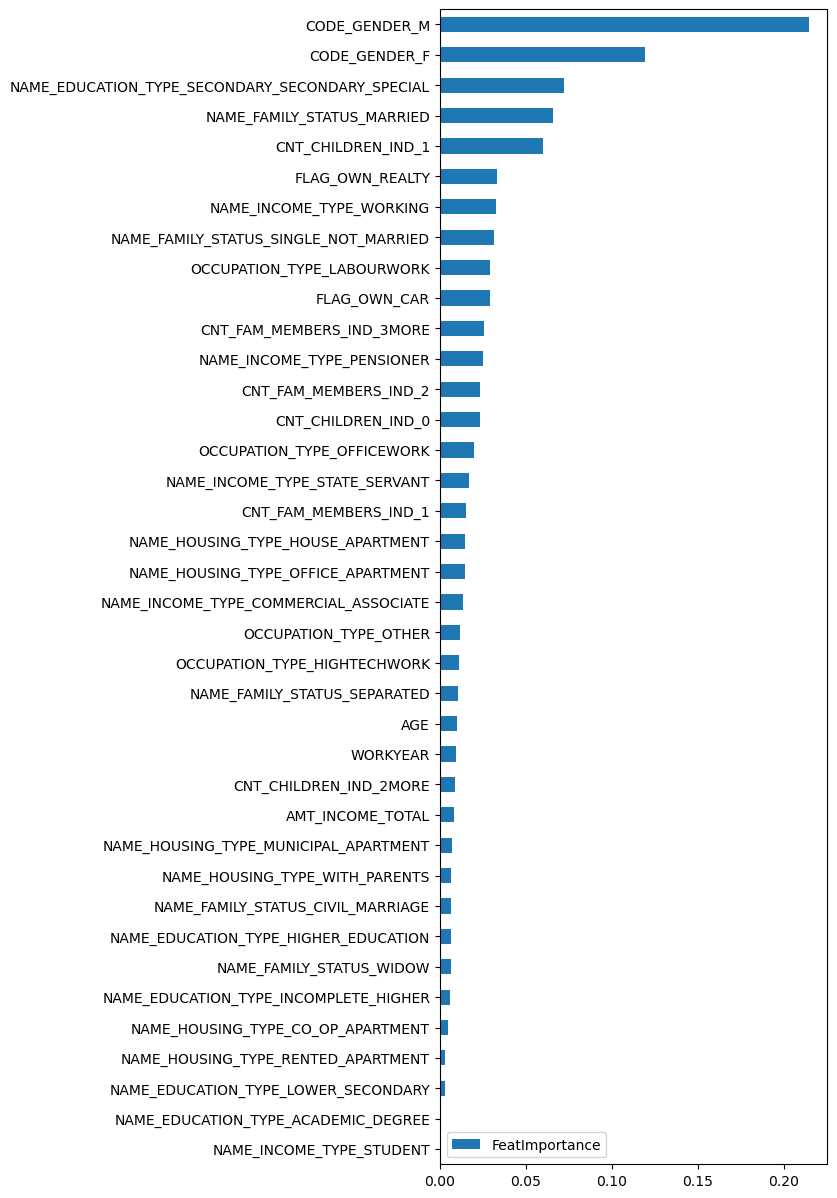

In [20]:
# Plot feature importance
feat_importance = pd.DataFrame(xgbm_local.feature_importances_,xgbm_local.feature_names_in_,columns=['FeatImportance'])
feat_importance.sort_values('FeatImportance').plot.barh(y='FeatImportance', figsize=(5,15))

### Scoring

In [23]:
scored_sdf = xgbm.predict(test_sdf)
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TEST_SCORED', mode='overwrite')

The version of package 'xgboost' in the local environment is 2.1.4, which does not fit the criteria for the requirement 'xgboost==2.1.1'. Your UDF might not work when the package version is different between the server and your local environment.


In [24]:
session.table('CREDIT_RISK_PREPARED_BALANCED_TEST_SCORED').show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Evaluation

Acccuracy: 0.986938
Precision: 0.9927458928952422
Recall: 0.9777264131119984
F1: 0.9851789117086598


<Axes: >

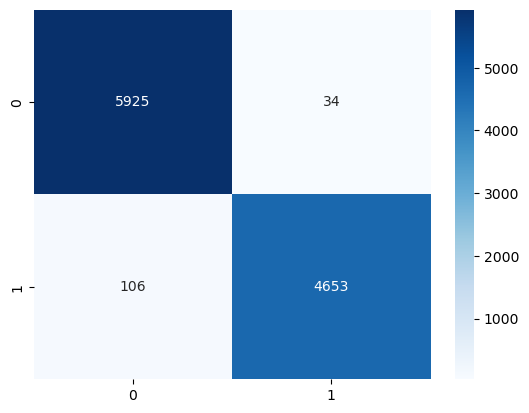

In [27]:
print('Acccuracy:', accuracy_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='OUTPUT_TARGET'))
print('Precision:', precision_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='OUTPUT_TARGET'))
print('Recall:', recall_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='OUTPUT_TARGET'))
print('F1:', f1_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='OUTPUT_TARGET'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_sdf, y_true_col_name='TARGET', y_pred_col_name='OUTPUT_TARGET')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

In [28]:
session.close()  # Close the Snowpark session